# Tarea Final NLP

Autor: Salvador Yábar Reaño

Estudio exploratorio de 3 modelos de clasificación de emociones. Dataset: https://github.com/fmplaza/EmoEvent/tree/master/splits

### Importar dataset y librerías

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("emoevent_es.csv", sep=None, engine='python', index_col=0) # Cargar dataset
df = df.drop(columns=["offensive"]) # Eliminar columna no necesaria
df.head()

,tweet,emotion
id,,
1,Acabo de ver la gran pérdida que estamos tenie...,sadness
2,USER ¿A que vamos a reconstruir Notre Dame ant...,sadness
3,Desde ayer andan sufriendo por el incendio de ...,anger
4,Muy afectada -como muchísima gente- por lo ocu...,sadness
5,Es una mierda lo que paso en HASHTAG pero plea...,disgust


Se observa la estructura del dataset. Se tienen las columnas 'tweet' y 'emotion'.

In [3]:
df.info() # Revisar cantidad de tweets y tipos de datos

<class 'pandas.core.frame.DataFrame'>
Index: 8409 entries, 1 to 8409
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8409 non-null   object
 1   emotion  8409 non-null   object
dtypes: object(2)
memory usage: 197.1+ KB


In [4]:
df["emotion"].value_counts()

emotion
others      4127
joy         1815
sadness     1009
anger        857
surprise     344
disgust      161
fear          96
Name: count, dtype: int64

Emotion cuenta con 7 categorías: others, joy, sadness, anger, surprise, disgust y fear.

Se observa una clara desproporción entre las clases, siendo la que menos ejemplos tiene la clase fear.

# Desarrollo

Para el desarrollo de este estudio exploratorio se seleccionaron 3 enfoques diferentes, cada uno empleando una aproximación distinta al problema de clasificación.

Se presentará el desarrollo de cada modelo, sus resultados y observaciones, y finalmente se compararán los resultados obtenidos entre los tres modelos.


## Modelo 1: TF-IDF + Logistic Regression

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
import re

In [6]:
nltk.download("stopwords")

tokenizer = ToktokTokenizer() # Inicializar tokenizador
stop_words = set(stopwords.words('spanish')) # stopwords en español

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salvador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def remove_tweet_chars(text): # Eliminar caracteres innecesarios en los tweets
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', str(text))
  text = re.sub('@[^\s]+','',text)
  return text

def remove_words(tokens):
    return [tok for tok in tokens if tok not in stop_words and not tok.isnumeric() and re.search(r'\w', tok)]

def preprocess_tweets_es(dataset, text_col="tweet"): # Procesar los tweets, aplicando las funciones anteriores y tokenizando
    dataset = dataset.copy()
    dataset["CLEAN"] = dataset[text_col].apply(remove_tweet_chars)
    dataset["CLEAN"] = dataset["CLEAN"].apply(lambda x: tokenizer.tokenize(x.lower()))
    dataset["CLEAN"] = dataset["CLEAN"].apply(remove_words)
    dataset["CLEAN_STR"] = dataset["CLEAN"].apply(lambda toks: " ".join(toks)) # Crear columna con tweets limpios como string
    return dataset

Aplicando las funciones anteriores, se obtiene un dataset con columnas CLEAN y CLEAN_STR.

In [8]:
df_clean = preprocess_tweets_es(df, text_col="tweet")
df_clean

,tweet,emotion,CLEAN,CLEAN_STR
id,,,,
1,Acabo de ver la gran pérdida que estamos tenie...,sadness,"[acabo, ver, gran, pérdida, momentos, hashtag,...",acabo ver gran pérdida momentos hashtag catedr...
2,USER ¿A que vamos a reconstruir Notre Dame ant...,sadness,"[user, vamos, reconstruir, notre, dame, mandar...",user vamos reconstruir notre dame mandar solo ...
3,Desde ayer andan sufriendo por el incendio de ...,anger,"[ayer, andan, sufriendo, incendio, hashtag, si...",ayer andan sufriendo incendio hashtag siquiera...
4,Muy afectada -como muchísima gente- por lo ocu...,sadness,"[afectada, -como, muchísima, gente-, ocurrido,...",afectada -como muchísima gente- ocurrido hasht...
5,Es una mierda lo que paso en HASHTAG pero plea...,disgust,"[mierda, paso, hashtag, please, dejen, subir, ...",mierda paso hashtag please dejen subir foto ha...
...,...,...,...,...
8405,"Dembele es un imbécil, neta es increíble lo pe...",anger,"[dembele, imbécil, neta, increíble, pendejo, e...",dembele imbécil neta increíble pendejo está. h...
8406,HASHTAG Puta q son desagradables los wnes del ...,anger,"[hashtag, puta, q, desagradables, wnes, barca,...",hashtag puta q desagradables wnes barca especi...
8407,Puta que me cae mal Suárez ctm HASHTAG,anger,"[puta, cae, mal, suárez, ctm, hashtag]",puta cae mal suárez ctm hashtag


In [9]:
df_clean['CLEAN'][1] # Tweet limpio como lista de tokens

['acabo',
 'ver',
 'gran',
 'pérdida',
 'momentos',
 'hashtag',
 'catedral',
 'hashtag',
 'llamas😭hoy',
 'humanidad',
 'perdido',
 'gran',
 'monumento',
 'arquitectónico',
 'url']

In [10]:
df_clean['CLEAN_STR'][1] # Tweet limpio como string

'acabo ver gran pérdida momentos hashtag catedral hashtag llamas😭hoy humanidad perdido gran monumento arquitectónico url'

### Funciones para resultados

In [11]:
# Matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# DF de resultados
def get_f1_per_class(y_true, y_pred, labels, model_name):
    report = classification_report(
        y_true, y_pred,
        target_names=labels,
        output_dict=True,
        zero_division=0
    )
    # Extraemos solo el f1-score por clase
    f1_scores = {cls: report[cls]['f1-score'] for cls in labels}
    return pd.DataFrame(f1_scores, index=[model_name])

df_results = pd.DataFrame() # Dataframe de resultados

Las columans obtenidas servirán tanto para el clasificador con Logistic Regression como con LSTM, ya que la segunda necesita el string completo.

              precision    recall  f1-score   support

       anger       0.40      0.54      0.46       171
     disgust       0.11      0.12      0.12        32
        fear       0.43      0.53      0.48        19
         joy       0.53      0.57      0.55       363
      others       0.73      0.59      0.65       826
     sadness       0.70      0.68      0.69       202
    surprise       0.23      0.48      0.31        69

    accuracy                           0.58      1682
   macro avg       0.45      0.50      0.47      1682
weighted avg       0.62      0.58      0.59      1682



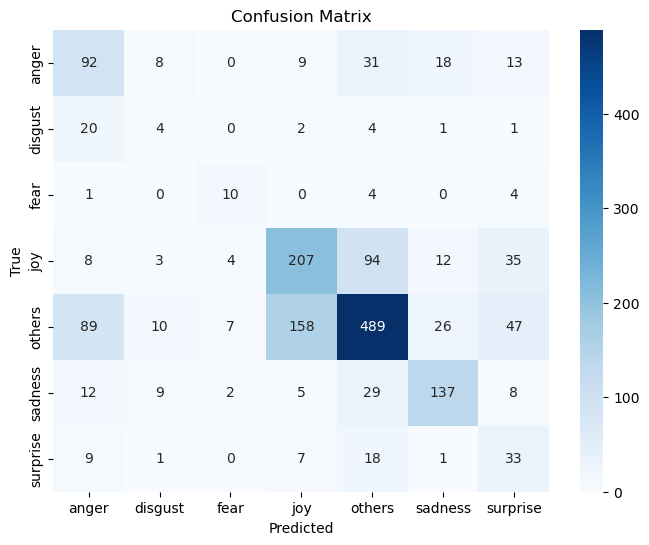

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Separar en conjunto de entrenamiento y prueba
X = df_clean["CLEAN_STR"]
y = df_clean["emotion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(lowercase=False)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# Regresión logística (clasificador)
clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

# Evaluación
print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, classes=clf.classes_)
f1_model1 = get_f1_per_class(y_test, y_pred, clf.classes_, "TF-IDF + LR")
df_results = pd.concat([df_results, f1_model1])

### Resultados modelo 1

Se observa que el modelo tuvo una precisión y recall muy bajos en la clase disgust. El disgusto puede estar asociado con el enojo, clase que predijo el modelo para estos ejemplos. Esto se relaciona con el número reducido de ejemplos de disgust, por lo que el modelo no consigue una buena generalización a partir de estos.

Por otro lado, se observa que gran parte de las predicciones fueron para la clase others. Al ser una clase que agrupa tweets variados, es comprensible que al no tener certeza de otras clases, el modelo prediga esta. Esto se refleja en el alto recall con una precisión media, recupera gran parte de los ejemplos en others, pero también clasifica ejemplos de otras clases en esta.

En general, los mejores resultados se dieron para joy, others y sadness. Las demás categorías tienen un F1-Score muy bajo. Esto se puede deber en gran medida a que existen más ejemplos para estas clases, así como que felicidad y tristeza son emociones que son más faciles de denotar.

El uso de métodos clásicos para el preprocesamiento (quitar caracteres y stopwords, tokenizar) es necesario para este modelo de clasificación, y sin embargo no se consiguen resultados destacables, lo que es esperable. De esta forma se demuestra la limitación de este método, ya que carece de la interpretación contextual, por lo que emociones más complejas no son predichas correctamente.

## Modelo 2: Embeddings + Red Recurrente (LSTM)

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight


In [14]:
MAX_NUM_WORDS = 10000   # Tamaño del vocabulario
MAX_SEQ_LEN   = 48

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>", filters='')
texts = df_clean["CLEAN_STR"].astype(str).tolist()
tokenizer.fit_on_texts(texts)

X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, padding="post", truncating="post")

le = LabelEncoder()
y_int = le.fit_transform(df_clean["emotion"])
y = tf.keras.utils.to_categorical(y_int, num_classes=len(le.classes_))

In [15]:
# Definir el modelo de red neuronal
EMBEDDING_DIM = 32

model = Sequential([
    Input(shape=(MAX_SEQ_LEN,)),
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, mask_zero=True),
    LSTM(16, dropout=0.6, recurrent_dropout=0.2, return_sequences=False),
    Dropout(0.6),
    Dense(len(le.classes_), activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=5e-4),
              metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 48, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,255 (1.23 MB)

 Trainable params: 323,255 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=np.argmax(y_train, axis=1)
)

# calcular class_weight con etiquetas enteras del train para balancear clases
y_train_int = np.argmax(y_train, axis=1)
classes = np.unique(y_train_int)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_int)
class_weight = {i: w for i, w in enumerate(weights)}

In [17]:
from pathlib import Path

MODEL_DIR  = Path("models/lstm_emotions")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "model.keras"

In [18]:
if MODEL_PATH.exists():
    print(f"Existe modelo guardado previamente: {MODEL_PATH}. Saltando el entrenamiento.")
    model = tf.keras.models.load_model(MODEL_PATH)

else:

  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      batch_size=64,
      epochs=25,
      verbose=1,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                          restore_best_weights=True, verbose=1),
                tf.keras.callbacks.ModelCheckpoint(filepath=str(MODEL_PATH), monitor='val_loss',
                                                    save_best_only=True, save_weights_only=False, verbose=1)],
      class_weight=class_weight
  )
  print(f"Guardando el modelo en: {MODEL_PATH}")

model.load_weights("models/lstm_emotions/model.keras")

Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1905 - loss: 1.8996
Epoch 1: val_loss improved from None to 1.93476, saving model to models\lstm_emotions\model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.1959 - loss: 1.9456 - val_accuracy: 0.3893 - val_loss: 1.9348
Epoch 2/25
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2633 - loss: 1.9769
Epoch 2: val_loss improved from 1.93476 to 1.92866, saving model to models\lstm_emotions\model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2588 - loss: 1.9402 - val_accuracy: 0.4517 - val_loss: 1.9287
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3089 - loss: 1.8995
Epoch 3: val_loss improved from 1.92866 to 1.89700, saving model to models\lstm_emotions\model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3168 - loss: 1.9228 - val_accuracy: 0.4205 - val_loss: 1.8970
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3085 - loss: 1.8439
Epoch 4: va

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
              precision    recall  f1-score   support

       anger       0.36      0.35      0.36       171
     disgust       0.08      0.25      0.13        32
        fear       0.08      0.42      0.14        19
         joy       0.35      0.33      0.34       363
      others       0.62      0.58      0.60       826
     sadness       0.79      0.63      0.70       202
    surprise       0.16      0.12      0.14        69

    accuracy                           0.48      1682
   macro avg       0.35      0.38      0.34      1682
weighted avg       0.52      0.48      0.50      1682



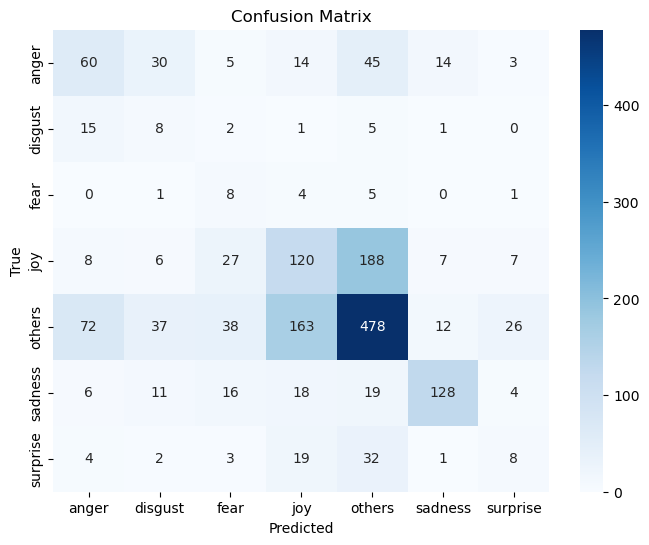

In [19]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
y_true_str = le.inverse_transform(y_true)
y_pred_str = le.inverse_transform(y_pred_classes)

print(classification_report(y_true, y_pred_classes, target_names=le.classes_, zero_division=0))
f1_model2 = get_f1_per_class(y_true_str, y_pred_str, le.classes_, "LSTM")
df_results = pd.concat([df_results, f1_model2])
plot_confusion_matrix(y_true_str, y_pred_str, classes=le.classes_)

### Resultados modelo 2:
Durante el entrenamiento, se observó que la red LSTM es propensa a presentar overfitting al conjunto de datos, por lo que se tuvo que aplicar técnicas de regularización (dropout) y disminuir algunos parámetros como la cantidad de neuronas para simplificar el modelo.

Tras varias iteraciones, se logró reducir el overfitting.

Si bien se obtuvo un menor desempeño en las clases que el modelo 1 predecía correctamente (joy, others, sadness), se obtuvieron mejores resultados para las demás clases.

Como se observa en la matriz de confusión, se tienen resultados más balanceados de precisión y recall para todas las clases.

Como en el modelo anterior, las clases de others y sadness destacan por tener un mejor desempeño que las demás.  

Este modelo puede interpretar el contexto de la oración gracias a emplear LSTM, de esta forma, se logra interpretar emociones más complejas que pueden ser expresadas de manera más sutil.

## Modelo 3: Fine-tune a BETO

El tercer modelo

In [20]:
df_bert = df.copy()
df_bert["text"] = df_bert["tweet"].apply(remove_tweet_chars)
df_bert = df_bert[df_bert["text"].str.len() > 0].reset_index(drop=True)

le = LabelEncoder()
df_bert["label"] = le.fit_transform(df_bert["emotion"])
num_labels = len(le.classes_)  # should be 7

X = df_bert["text"].values
y = df_bert["label"].values

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print("Sizes:", len(X_train), len(X_val), len(X_test))
print("Classes:", list(le.classes_))

Sizes: 6727 841 841
Classes: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']


In [21]:
from transformers import AutoTokenizer
import tensorflow as tf

MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
SAVE_DIR   = Path("beto-emotions-tf")
MAX_LEN = 96
BATCH   = 16
NUM_LABELS = len(le.classes_)

# Cargar si existe tokenizer guardado
if SAVE_DIR.exists():
    print("Loading tokenizer from saved folder…")
    tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
else:
    print("Downloading tokenizer from Hugging Face…")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


# ---------- Encode datasets ----------
enc_train = tokenizer(list(X_train), truncation=True, padding="max_length",
                      max_length=MAX_LEN, return_tensors="np")
enc_val   = tokenizer(list(X_val),   truncation=True, padding="max_length",
                      max_length=MAX_LEN, return_tensors="np")
enc_test  = tokenizer(list(X_test),  truncation=True, padding="max_length",
                      max_length=MAX_LEN, return_tensors="np")


train_ds = tf.data.Dataset.from_tensor_slices((
    {"input_ids": enc_train["input_ids"], "attention_mask": enc_train["attention_mask"]},
    y_train
)).shuffle(2048, seed=42).batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((
    {"input_ids": enc_val["input_ids"], "attention_mask": enc_val["attention_mask"]},
    y_val
)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((
    {"input_ids": enc_test["input_ids"], "attention_mask": enc_test["attention_mask"]},
    y_test
)).batch(BATCH)

c:\Users\Salvador\anaconda3\envs\tarea_nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Salvador\anaconda3\envs\tarea_nlp_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Salvador\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
import os
os.environ["TF_KERAS"] = "1"

import tf_keras as keras
from tf_keras.optimizers import Adam
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import TFAutoModelForSequenceClassification

# Saltar el entrenamiento si existe un modelo entrenado localmente
if SAVE_DIR.exists():
    print("Found saved model, loading instead of training.")
    model = TFAutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
    history = None
else:
    print("Training new model…")
    model = TFAutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_LABELS
    )
    model.compile(
        optimizer=Adam(learning_rate=2e-5),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )
    cbs = [
        EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6),
    ]

    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c, w in zip(classes, weights)}

    history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=cbs, verbose=1, class_weight=class_weight)
    model.save_pretrained(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)


Training new model…



TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3

 96/421 [=====>........................] - ETA: 23:51 - loss: 1.8129 - accuracy: 0.2005

In [ ]:
# 1) Get logits
all_logits = []
for inputs, _ in test_ds:
    out = model(inputs, training=False)
    all_logits.append(out.logits.numpy())
logits = np.concatenate(all_logits, axis=0)

# 2) Integers → strings
y_pred = np.argmax(logits, axis=1)
y_true = y_test

y_true_str = le.inverse_transform(y_true)
y_pred_str = le.inverse_transform(y_pred)

f1_model3 = get_f1_per_class(y_true_str, y_pred_str, le.classes_, "BETO")
df_results = pd.concat([df_results, f1_model3])

# Resultados
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))
plot_confusion_matrix(y_true_str, y_pred_str, classes=le.classes_)

### Resultados Modelo 3:


Como se observó en los otros modelos, las clases de joy, others, y sadness obtuvieron el mejor desempeño con F1-Scores mayores a 0.6.

Algo a resaltar en este modelo es que una gran cantidad de ejemplos pertenecientes a anger fueron clasificados como disgust por el modelo. De esta forma, a pesar de tener un recall del 100%, la precisión en esta clase es considerablemente baja (13%). Esto sugiere que el modelo tiene dificultad en diferenciar emociones negativas.





# Conclusiones

Tabla de F1-Scores para los 3 modelos:

In [ ]:
print(df_results.T)

A partir de la tabla, se puede observar mejor cómo los 3 modelos se comparan entre sí.

En primer lugar, BETO consigue el mayor F1-Score en la mayoría de categorías, seguido del modelo 1, que consigue el mejor desempeño en anger y fear. El modelo 2 no llega a superar a los otros dos en ninguna clase.

Lo anterior puede deberse a varios factores. Las clases de anger y fear pueden estar representadas por palabras clave específicos, que el modelo 1 basado en frecuencia clasifica correctamente en estas clases.

Por otro lado, al tener un dataset relativamente pequeño, un modelo de Deep Learning como LSTM tiende a experimentar overfitting y no aprender buenas generalizaciones.

BETO destaca por su capacidad para capturar relaciones más complejas entre palabras, lo que se refleja en su mejor rendimiento. No obstante, esto tiene un costo computacional importante, su entrenamiento requiere considerablemente más tiempo y recursos que los otros modelos. A pesar de ello, su mejora sobre el modelo de Logistic Regression es clara, aunque no drástica.

En conclusión, para este problema y bajo las limitaciones del dataset, BETO es la opción más robusta y precisa. Sin embargo, si se buscan modelos más livianos, enfoques clásicos como TF-IDF + Logistic Regression aún ofrecen resultados razonablemente competitivos.